# modeling

In [62]:

import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = wr.get_clean_data(start2018=True)
sdf = s.get_summary_df(df)
sdf = wr.add_date_features(sdf)

### Spit For modeling

In [74]:
train, test = wr.split_data(df)

In [75]:
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

In [76]:
pd.concat([validate.tail(1), test.head(1)])

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2022-06-30,Navarro County,Local Government,Corsicana,CDW Government LLC,Vernon Hills,"75,110.00",4.00,"1,331.22",315940,2022-06-30,2022-06-30,2022,2,June,Thursday,6,26,3,181,"5,324.88"
2022-07-01,Godley Independent School District,K-12,Godley,CDW Government LLC,Vernon Hills,"76,044.00",1.00,67.46,0310022241,2022-07-13,2022-07-01,2022,3,July,Friday,7,26,4,182,67.46


In [77]:
X_train = pd.DataFrame(train.purchase_amount.copy().resample('D').sum())
X_validate = pd.DataFrame(validate.purchase_amount.copy().resample('D').sum())
X_test = pd.DataFrame(test.purchase_amount.copy().resample('D').sum())

<AxesSubplot:xlabel='order_date'>

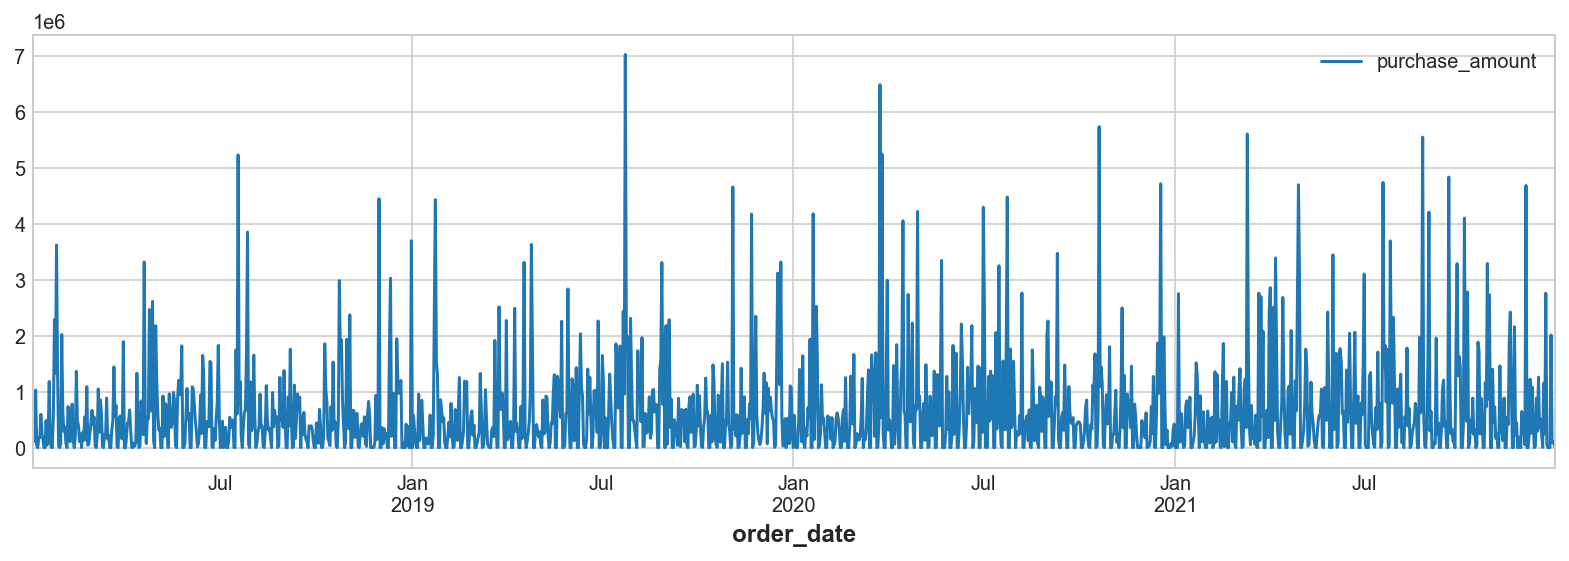

In [41]:
ts = X_train.copy()
ts.plot()

In [80]:
baseline = X_train.purchase_amount.mean()

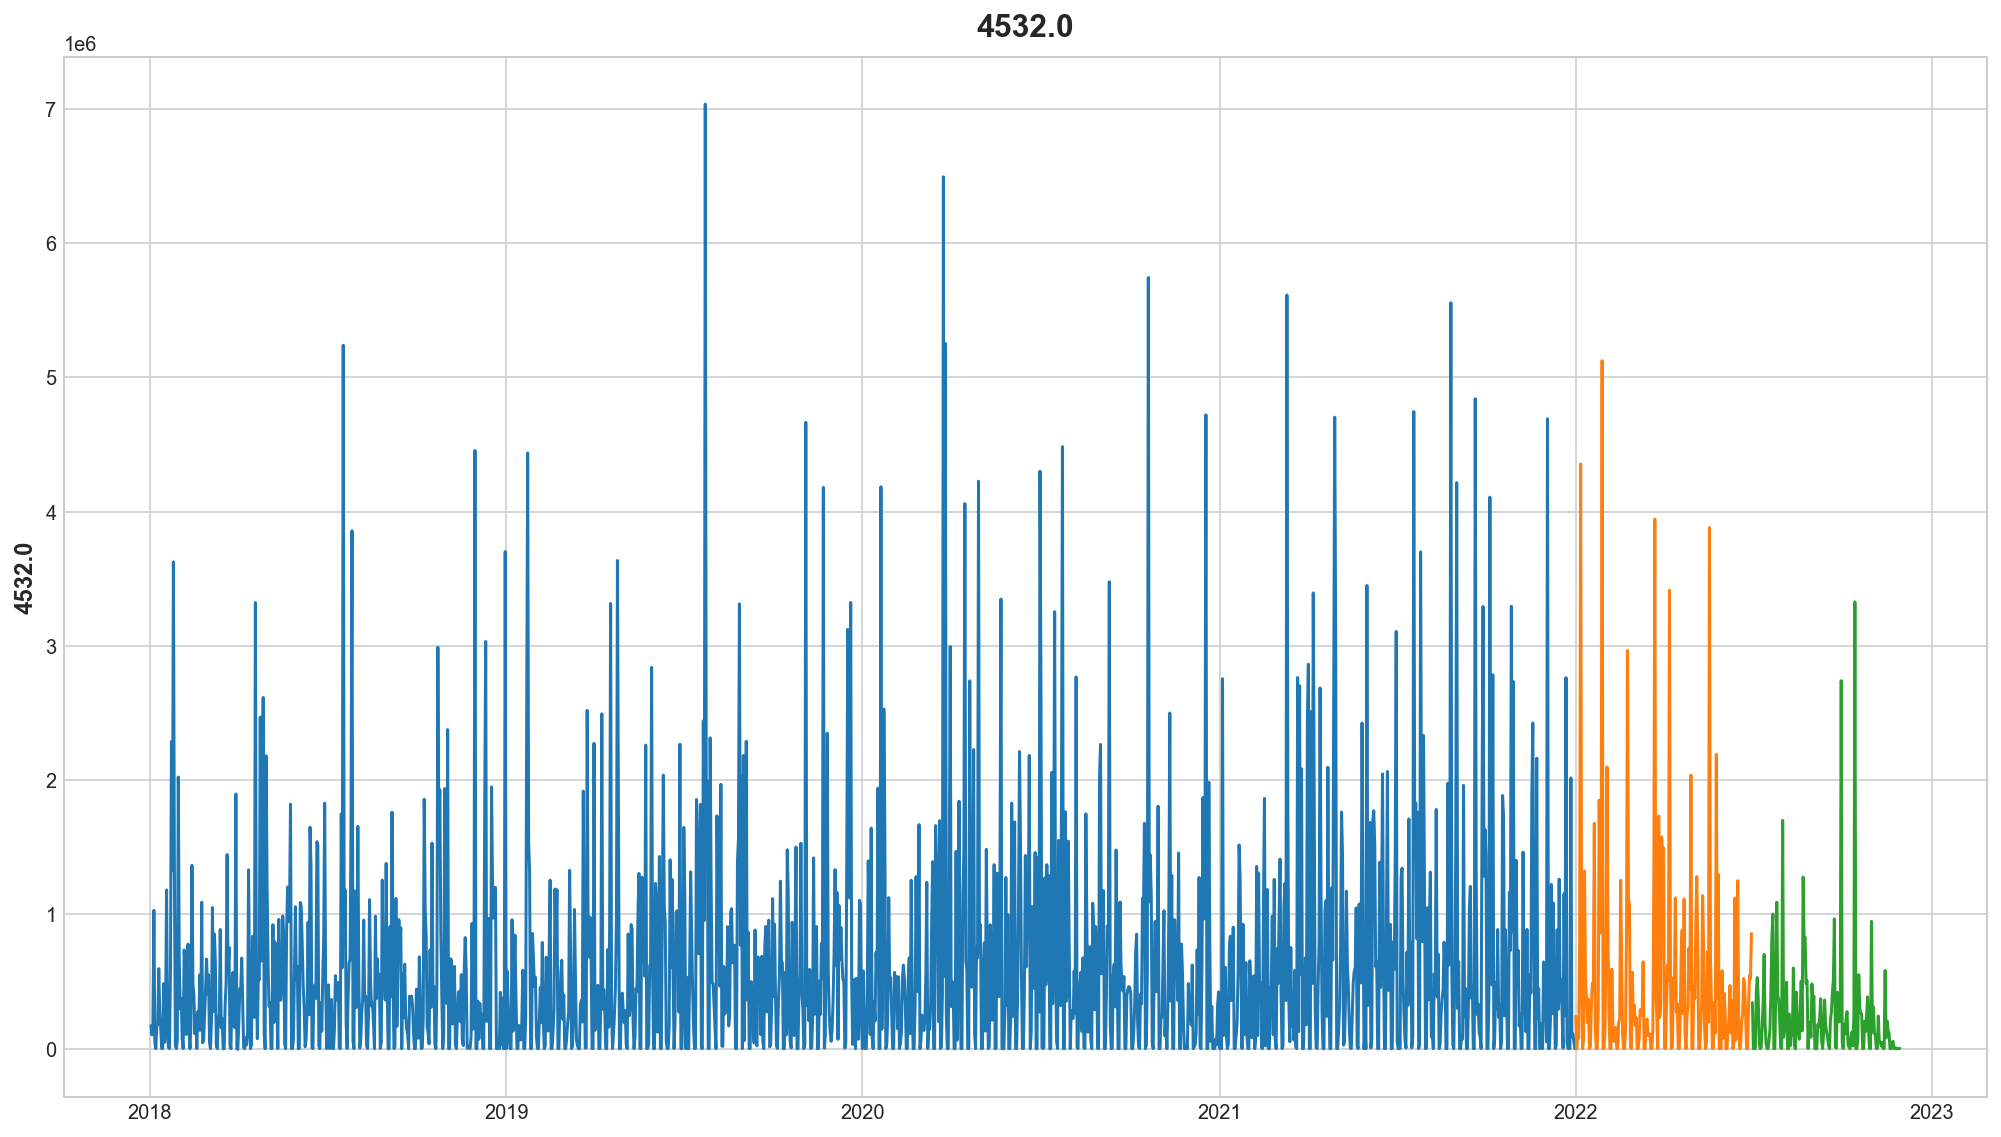

In [45]:
plt.figure(figsize=(14,8))
plt.plot(X_train)
plt.plot(X_validate)
plt.plot(X_test)
plt.ylabel(col)
plt.title(col)
plt.show()


### evaluate

In [46]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [47]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [48]:
# empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


In [49]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average

In [68]:
# compute simple average
purchase_amount = round(X_train.purchase_amount.mean(), 2)
purchase_amount

654835.74

In [82]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'purchase_amount': [purchase_amount],},
                          index=X_validate.index)
    return yhat_df

In [83]:
yhat_df = make_predictions(purchase_amount)
yhat_df.head()

,purchase_amount
order_date,
2022-01-01,"654,835.74"
2022-01-02,"654,835.74"
2022-01-03,"654,835.74"
2022-01-04,"654,835.74"
2022-01-05,"654,835.74"


In [85]:
mean_squared_error(X_validate.purchase_amount, yhat_df.purchase_amount)

656510633463.2124

purchase_amount -- RMSE: 650141


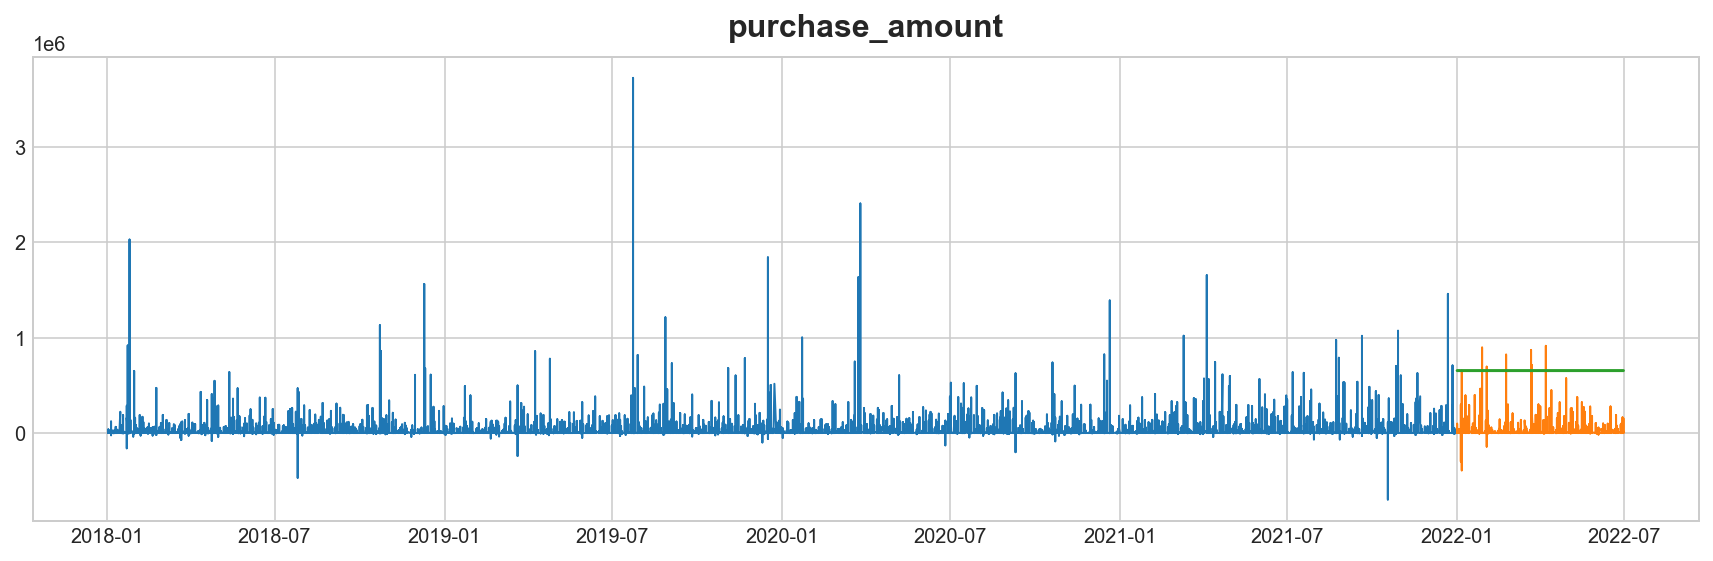

In [71]:
plot_and_eval("purchase_amount")

In [72]:
eval_df = append_eval_df(model_type='simple_averave', 
                        target_var = 'purchase_amount')
eval_df

,model_type,target_var,rmse
0,simple_averave,purchase_amount,"28,366.00"
1,simple_averave,purchase_amount,"650,141.00"


In [73]:
X_train.shape

(1460, 1)